## Loading metrics

In [839]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
# import geopandas as gpd
import json
from concurrent.futures import ThreadPoolExecutor
import os

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import networkx as nx
from cdlib import algorithms, evaluation
from cdlib import readwrite


# Consistent theme
import plotly.io as pio
pio.templates.default = "plotly_white"

In [840]:
def merge_all_metrics_for_triplet_key(triplet_key, data_dir="../cdlib-trial/data"):
    """
    Reads all metrics.csv files in ../data/{triplet-key}/**/metrics.csv,
    merges them on column headers (outer join), fills missing with NaN,
    and returns the merged DataFrame.
    """
    base_path = os.path.join(data_dir, triplet_key)
    metrics_files = []
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file == "metrics.csv":
                metrics_files.append(os.path.join(root, file))
    if not metrics_files:
        print(f"No metrics.csv files found for triplet key: {triplet_key}")
        return pd.DataFrame()
    dfs = []
    for f in metrics_files:
        df = pd.read_csv(f)
        dfs.append(df)
    merged = pd.concat(dfs, axis=0, join="outer", ignore_index=True, sort=False)
    # make algo column first
    if 'algo' in merged.columns:
        cols = ['algo'] + [col for col in merged.columns if col != 'algo']
        merged = merged[cols]
    
    # make algo column the headers in transposed format
    if 'algo' in merged.columns:
        merged = merged.set_index('algo').T
        merged.index.name = 'metric'

    # save to ../data/thesis/triplet_key/metrics.csv
    output_path = os.path.join("../data/thesis", triplet_key, "merged_metrics.csv")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    merged.to_csv(output_path)
    print(f"Merged metrics saved to {output_path}")
    # Return the merged DataFrame
    return merged

In [841]:
merge_all_metrics_for_triplet_key("neo4j")

Merged metrics saved to ../data/thesis/neo4j/merged_metrics.csv


algo,slpa_on_leiden_level0,hierarchical_leiden_level0,hierarchical_leiden_level1,hierarchical_leiden_level2,slpa
metric,,,,,
newman_girvan_modularity,NaN,0.418266,0.405701,0.001521,NaN
erdos_renyi_modularity,NaN,0.419091,0.405649,0.003968,NaN
overlapping_modularity,0.011855,NaN,NaN,NaN,0.002199
conductance,0.579832,0.555146,0.582412,0.859689,0.414822
num_communities,985.000000,112.000000,984.000000,23.000000,44.000000
avg_size,148.870051,1309.250000,149.020325,38.652174,3541.681818
max_size,2376.000000,4682.000000,2290.000000,88.000000,129175.000000
min_size,21.000000,368.000000,6.000000,2.000000,162.000000
num_nodes_in_communities,146636.000000,146636.000000,146636.000000,889.000000,146636.000000


In [842]:
merge_all_metrics_for_triplet_key("pub")

Merged metrics saved to ../data/thesis/pub/merged_metrics.csv


algo,slpa_on_leiden_level0,hierarchical_leiden_level0,hierarchical_leiden_level1,hierarchical_leiden_level2,slpa
metric,,,,,
newman_girvan_modularity,NaN,0.450578,0.414672,0.000204,NaN
erdos_renyi_modularity,NaN,0.451210,0.422181,0.000600,NaN
overlapping_modularity,0.011102,NaN,NaN,NaN,0.003816
conductance,0.554861,0.524232,0.561995,0.800331,0.429308
num_communities,631.000000,105.000000,635.000000,2.000000,99.000000
avg_size,164.890650,990.914286,158.434646,72.000000,1184.626263
max_size,2438.000000,2438.000000,1676.000000,73.000000,80262.000000
min_size,24.000000,314.000000,10.000000,71.000000,118.000000
num_nodes_in_communities,104046.000000,104046.000000,100606.000000,144.000000,104046.000000


In [843]:
merge_all_metrics_for_triplet_key('trial')

Merged metrics saved to ../data/thesis/trial/merged_metrics.csv


algo,slpa_on_leiden_level0,hierarchical_leiden_level0,hierarchical_leiden_level1,slpa
metric,,,,
newman_girvan_modularity,NaN,0.473877,0.409699,NaN
erdos_renyi_modularity,NaN,0.474540,0.431786,NaN
overlapping_modularity,0.010569,NaN,NaN,0.008435
conductance,0.527990,0.493741,0.535929,0.449553
num_communities,354.000000,84.000000,350.000000,225.000000
avg_size,164.042373,691.321429,154.705714,287.568889
max_size,1575.000000,1593.000000,645.000000,21039.000000
min_size,38.000000,106.000000,6.000000,84.000000
num_nodes_in_communities,58071.000000,58071.000000,54147.000000,58071.000000


## Loading communities

In [844]:
comm_path = os.path.join("../cdlib-trial/data", "neo4j", "slpa", "communities.csv")
slpa_communities = readwrite.read_community_csv(comm_path, nodetype=int)

comm_path = os.path.join("../cdlib-trial/data", "neo4j", "hierarchical_leiden", "communities_level0.csv")
heirarchical_leiden_level0 = readwrite.read_community_csv(comm_path, nodetype=int)

comm_path = os.path.join("../cdlib-trial/data", "neo4j", "hierarchical_leiden", "communities_level1.csv")
heirarchical_leiden_level1 = readwrite.read_community_csv(comm_path, nodetype=int)

comm_path = os.path.join("../cdlib-trial/data", "neo4j", "hierarchical_leiden", "communities_level2.csv")
heirarchical_leiden_level2 = readwrite.read_community_csv(comm_path, nodetype=int)

comm_path = os.path.join("../cdlib-trial/data", "neo4j", "slpa_on_leiden_level0", "communities.csv")
slpa_on_leiden_level0 = readwrite.read_community_csv(comm_path, nodetype=int)

parents_path = os.path.join("../cdlib-trial/data", "neo4j", "hierarchical_leiden", "parents.csv")
parents_df = pd.read_csv(parents_path)
parents_df = parents_df.drop_duplicates()

In [845]:
def getGraphCharacteristics(triplet_key):
    # from triplets file and mapping file, get number of nodes and edges
    triplets_path = os.path.join("../cdlib-trial/data", triplet_key, f"kg_triplets_for_{triplet_key}.csv")
    triplets_df = pd.read_csv(triplets_path)
    triplets_df = triplets_df.drop_duplicates()
    edgesCount = triplets_df.shape[0]
    mapping_path = os.path.join("../cdlib-trial/data", triplet_key, "mapping.csv")
    mapping_df = pd.read_csv(mapping_path)
    mapping_df = mapping_df.drop_duplicates()
    nodesCount = mapping_df.shape[0]
    print(f"Triplet key: {triplet_key}, Nodes: {nodesCount}, Edges: {edgesCount}")
    # return nodesCount, edgesCount

In [846]:
getGraphCharacteristics("trial")

Triplet key: trial, Nodes: 58071, Edges: 126079


## Understanding Leiden splits (max_cluster_size=100)

In [847]:
print("Level 0 Hierarchical Leiden Communities")
# find the number of nodes belonging to communities whose size is greater than 100
comm_sizes = [len(c) for c in heirarchical_leiden_level0.communities]
large_comm_count = sum(1 for size in comm_sizes if size > 100)
print(f"Number of communities with size > 100: {large_comm_count}")
num_nodes_in_large_comms = sum(size for size in comm_sizes if size > 100)
print(f"Total number of nodes in communities with size > 100: {num_nodes_in_large_comms}")


print("Level 1 Hierarchical Leiden Communities")
# find the number of nodes belonging to communities whose size is greater than 100
comm_sizes = [len(c) for c in heirarchical_leiden_level1.communities]
large_comm_count = sum(1 for size in comm_sizes if size > 100)
print(f"Number of communities with size > 100: {large_comm_count}")
num_nodes_in_large_comms = sum(size for size in comm_sizes if size > 100)
print(f"Total number of nodes in communities with size > 100: {num_nodes_in_large_comms}")
max_comm_size = max(comm_sizes)
print(f"Maximum community size: {max_comm_size}")

'''
Level 0 Hierarchical Leiden Communities
Number of communities with size > 100: 112
Total number of nodes in communities with size > 100: 146636
Level 1 Hierarchical Leiden Communities
Number of communities with size > 100: 784
Total number of nodes in communities with size > 100: 131230

since 131230 is much large than 889, many nodes not close enough are left out of the communities.
'''


Level 0 Hierarchical Leiden Communities
Number of communities with size > 100: 112
Total number of nodes in communities with size > 100: 146636
Level 1 Hierarchical Leiden Communities
Number of communities with size > 100: 784
Total number of nodes in communities with size > 100: 131230
Maximum community size: 2290


'\nLevel 0 Hierarchical Leiden Communities\nNumber of communities with size > 100: 112\nTotal number of nodes in communities with size > 100: 146636\nLevel 1 Hierarchical Leiden Communities\nNumber of communities with size > 100: 784\nTotal number of nodes in communities with size > 100: 131230\n\nsince 131230 is much large than 889, many nodes not close enough are left out of the communities.\n'

In [848]:
len(heirarchical_leiden_level1.communities)

984

In [849]:
parents_df[parents_df['level'] == 1]

,community_id,parent_community_id,level
146636,112,0,1
146745,113,0,1
146888,114,0,1
147035,115,0,1
147157,116,0,1
...,...,...,...
292448,1091,111,1
292595,1092,111,1
292693,1093,111,1
292825,1094,111,1


In [850]:
level1_parents = parents_df[parents_df['level'] == 1]
# append size using heirarchical_leiden_level1.communities
level1_parents['size'] = level1_parents['community_id'].apply(
    lambda x: len(heirarchical_leiden_level1.communities[x-112])
)
level1_parents[level1_parents['size'] > 100].sort_values(by='size', ascending=False)

,community_id,parent_community_id,level,size
146636,112,0,1,2290
146745,113,0,1,1561
146888,114,0,1,1402
147035,115,0,1,1327
147157,116,0,1,1268
...,...,...,...,...
262683,891,86,1,101
262820,892,86,1,101
262899,893,86,1,101
263018,894,86,1,101


In [851]:
level1_parents[level1_parents['size'] >= 100]['community_id'].value_counts().sort_index()

community_id
112    1
113    1
114    1
115    1
116    1
      ..
897    1
898    1
899    1
900    1
901    1
Name: count, Length: 790, dtype: int64

In [852]:
level2_parents = parents_df[parents_df['level'] == 2]
level2_parents['size'] = level2_parents['community_id'].apply(
    lambda x: len(heirarchical_leiden_level2.communities[x-1096])
)
level2_parents

,community_id,parent_community_id,level,size
293272,1096,416,2,88
293354,1097,416,2,85
293415,1098,449,2,82
293476,1099,449,2,61
293536,1100,815,2,61
293587,1101,815,2,60
293638,1102,945,2,58
293656,1103,945,2,51
293664,1104,945,2,51
293706,1105,945,2,45


In [853]:
# print level1_parents where community_id is in level2_parents['parent_id']
level1_parents[level1_parents['community_id'].isin(level2_parents['parent_community_id'])].sort_values(by='size', ascending=False)

,community_id,parent_community_id,level,size
188211,416,33,1,148
192385,449,36,1,146
248748,815,79,1,109
269995,945,92,1,91
270189,947,92,1,91
284489,1037,104,1,69


## Adding node_id to patient df

In [854]:
triplet_key = "neo4j"
data_dir = "../cdlib-trial/data"

# Load mapping.csv (int_id -> node_name)
mapping = pd.read_csv(os.path.join(data_dir, triplet_key, "mapping.csv"))
# Convert mapping DataFrame to dictionary
mapping = mapping.set_index('node')['original_label'].to_dict()
rev_mapping = {v: k for k, v in mapping.items()}

# Load patient and mutation data
patient_df = pd.read_csv("../data/thesis/cll_broad_2022_clinical_data_thesis.csv")
mutation_df = pd.read_csv("../data/thesis/cll_broad_2022_mutations_thesis.csv")

In [855]:
# Add nodeId to patient_df
patient_df['Patient'] = patient_df['patientId'].apply(lambda x: f"Patient_{x}")
patient_df['nodeId'] = patient_df['Patient'].apply(lambda x: rev_mapping.get(x, None))

# Add nodeId to mutation_df
mutation_df['Patient'] = mutation_df['patientId'].apply(lambda x: f"Patient_{x}")
mutation_df['nodeId'] = mutation_df['Patient'].apply(lambda x: rev_mapping.get(x, None))

In [856]:
display(patient_df.head()[['nodeId', 'patientId']])
display(mutation_df.head()[['nodeId', 'patientId']])

,nodeId,patientId
0,0,P-CRC-0001
1,27,P-CRC-0002
2,36,P-CRC-0003
3,45,P-CRC-0004
4,59,P-CRC-0005


,nodeId,patientId
0,0,P-CRC-0001
1,0,P-CRC-0001
2,0,P-CRC-0001
3,0,P-CRC-0001
4,0,P-CRC-0001


## Add comm_id to patient_df from Leiden level 0

In [857]:
# join based on nodeId
def join_communities_with_patient_data(community, patient_df):
    """
    Joins communities with patient data based on nodeId.
    """
    communities = community.communities
    communities_df = pd.DataFrame({
        'nodeId': [node for comm in communities for node in comm],
        'community': [idx for idx, comm in enumerate(communities) for node in comm]
    })
    
    merged_df = pd.merge(patient_df, communities_df, on='nodeId', how='left')
    return merged_df

In [858]:
leiden0_patient_df = join_communities_with_patient_data(heirarchical_leiden_level0, patient_df)
leiden0_patient_df.head(10)[['nodeId', 'community', 'Patient', 'patientId']]

,nodeId,community,Patient,patientId
0,0,88,Patient_P-CRC-0001,P-CRC-0001
1,27,8,Patient_P-CRC-0002,P-CRC-0002
2,36,26,Patient_P-CRC-0003,P-CRC-0003
3,45,76,Patient_P-CRC-0004,P-CRC-0004
4,59,72,Patient_P-CRC-0005,P-CRC-0005
5,64,56,Patient_P-CRC-0006,P-CRC-0006
6,72,9,Patient_P-CRC-0007,P-CRC-0007
7,82,39,Patient_P-CRC-0008,P-CRC-0008
8,89,72,Patient_P-CRC-0009,P-CRC-0009
9,99,19,Patient_P-CRC-0010,P-CRC-0010


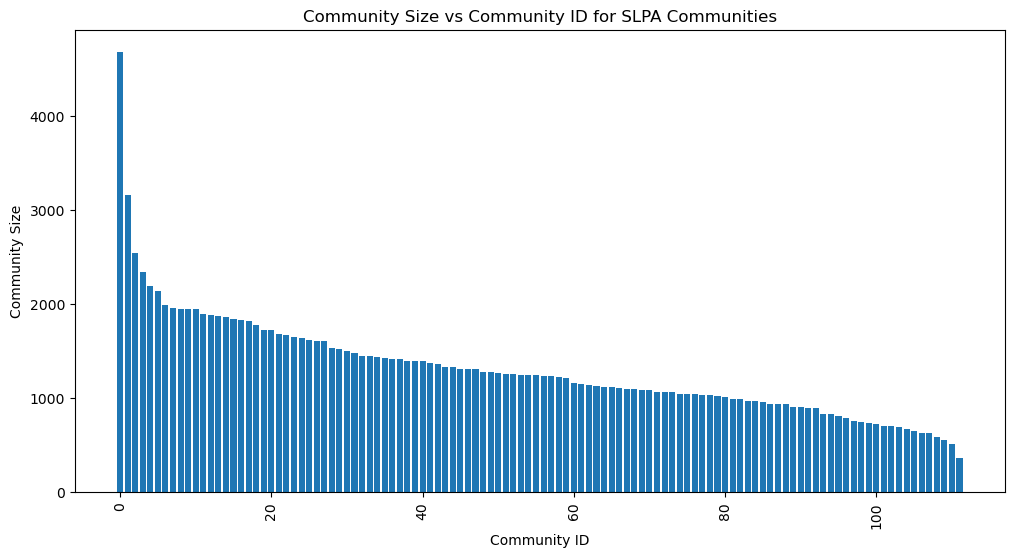

In [859]:
# plot community size vs community id 
comm_sizes = [len(c) for c in heirarchical_leiden_level0.communities]
plt.figure(figsize=(12, 6))
plt.bar(range(len(comm_sizes)), comm_sizes)
plt.xlabel('Community ID')
plt.ylabel('Community Size')
plt.title('Community Size vs Community ID for SLPA Communities')
plt.xticks(rotation=90)
plt.show()

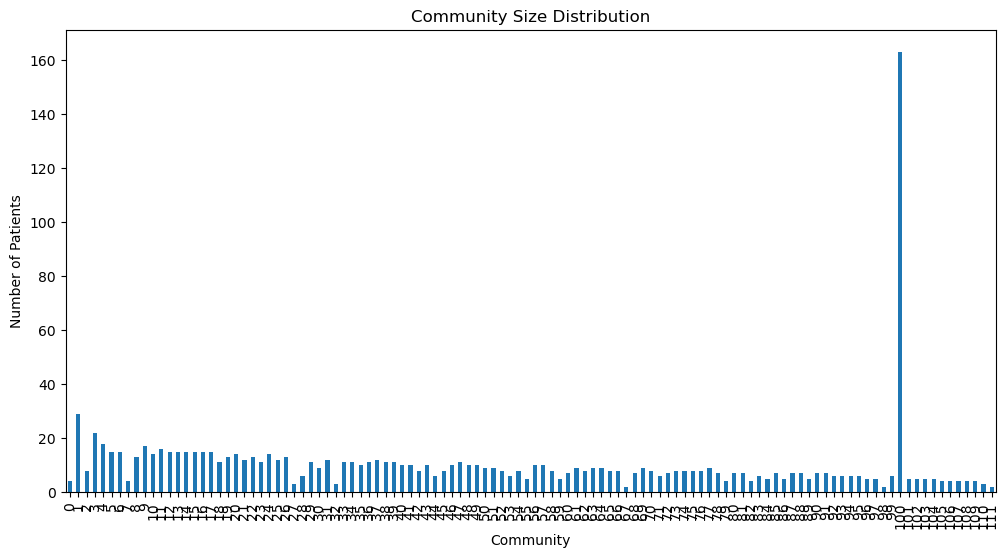

In [860]:
leiden0_patient_df['community'].value_counts().sort_index().plot(kind='bar', figsize=(12, 6), title='Community Size Distribution')
plt.xlabel('Community')
plt.ylabel('Number of Patients')
plt.show()

In [861]:
# get patient count with non null community
print(f"Total patients with non-null community in level 0: {leiden0_patient_df['community'].notnull().sum()}")

Total patients with non-null community in level 0: 1143


In [862]:
big_group = leiden0_patient_df[leiden0_patient_df['community'] == 100]
len(big_group)

163

In [863]:
big_group['COHORT'].value_counts()

COHORT
ICGC      67
GCLLSG    61
DFCI      32
MDACC      2
NHLBI      1
Name: count, dtype: int64

In [864]:
big_group['originId'].value_counts()

originId
1    67
7    31
6    30
3    25
5     7
9     2
8     1
Name: count, dtype: int64

In [865]:
big_group['CLL_EPITYPE'].value_counts()

CLL_EPITYPE
unclassified    108
m-CLL            25
n-CLL            24
i-CLL             6
Name: count, dtype: int64

In [866]:
big_group['TUMOR_MOLECULAR_SUBTYPE'].value_counts()

TUMOR_MOLECULAR_SUBTYPE
U-CLL    80
M-CLL    67
Name: count, dtype: int64

## Add comm_id to patient_df from Leiden level 1

In [867]:
leiden1_patient_df = join_communities_with_patient_data(heirarchical_leiden_level1, patient_df)
leiden1_patient_df.head(10)[['nodeId', 'community', 'Patient', 'patientId']]
print(f"Total patients with non-null community in level 1: {leiden1_patient_df['community'].notnull().sum()}")

Total patients with non-null community in level 1: 1143


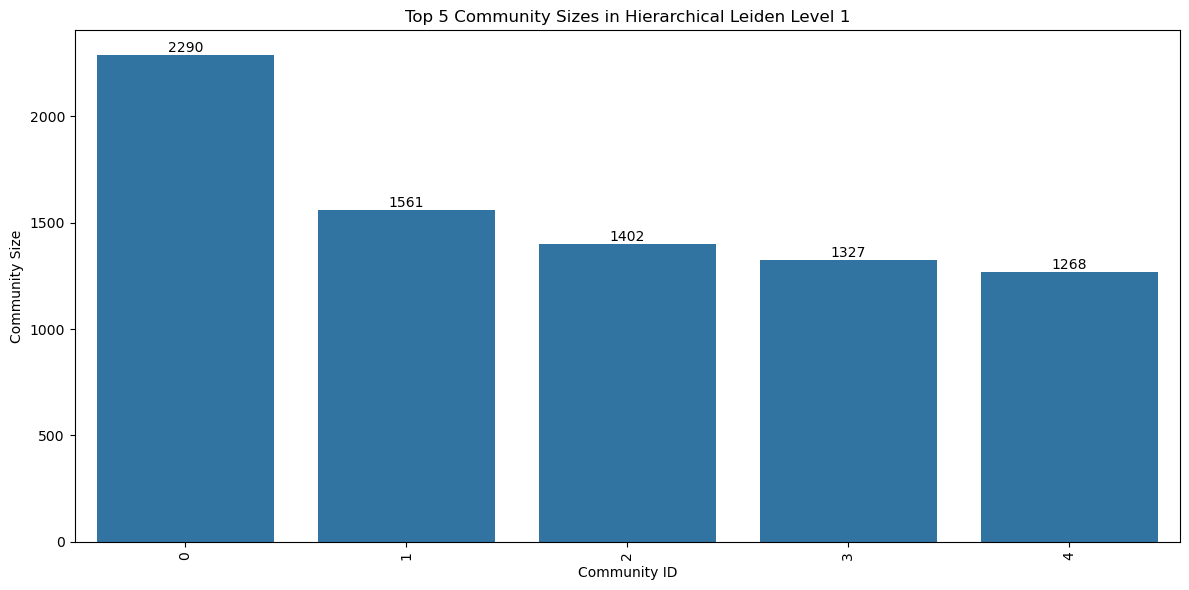

In [868]:
# get node distribution in ledien level 1 communities and plot top 5
comm_sizes = [len(c) for c in heirarchical_leiden_level1.communities]
# top_5_comm_sizes = sorted(comm_sizes, reverse=True)[:5]
top_5_comm_sizes = sorted(comm_sizes, reverse=True)[:5]
top_5_comm_sizes_df = pd.DataFrame(top_5_comm_sizes, columns=['size'])
top_5_comm_sizes_df['community'] = range(len(top_5_comm_sizes_df))  
plt.figure(figsize=(12, 6))
sns.barplot(data=top_5_comm_sizes_df, x='community', y='size')
plt.xlabel('Community ID')
plt.ylabel('Community Size')
plt.title('Top 5 Community Sizes in Hierarchical Leiden Level 1')
plt.xticks(rotation=90)
# annotate the size on top of each bar
for index, row in top_5_comm_sizes_df.iterrows():
    plt.text(row.name, row['size'], row['size'], color='black', ha="center", va="bottom")
plt.tight_layout()
plt.show()

In [869]:
comm_patient_count = leiden1_patient_df['community'].value_counts().sort_index()
print("Number of communities in level 1 with 1 patient: ", (comm_patient_count == 1).sum())
print("Number of communities in level 1 with 2 patients: ", (comm_patient_count == 2).sum())
# print top 10 communities with patient count
top_10_communities = comm_patient_count.nlargest(10)
print("Top 10 communities with patient count:")
print(top_10_communities)

# get which community id has no patients 
for community_id in range(len(heirarchical_leiden_level1.communities)):
    if community_id not in leiden1_patient_df['community'].unique():
        print(f"Community ID {community_id} has no patients.")
    

Number of communities in level 1 with 1 patient:  974
Number of communities in level 1 with 2 patients:  5
Top 10 communities with patient count:
community
671    72
51     64
889    19
982     4
150     2
366     2
593     2
774     2
964     2
0       1
Name: count, dtype: int64
Community ID 536 has no patients.


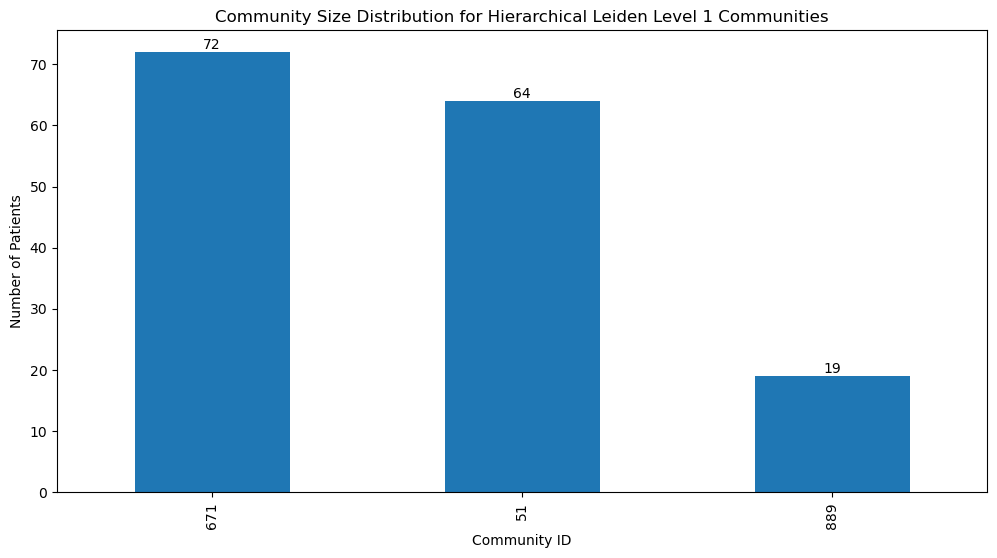

In [870]:
# get node distribution in communities
comm_sizes = leiden1_patient_df['community'].value_counts().sort_index()
# get 5 biggest communities
comm_sizes = comm_sizes.nlargest(3)
plt.figure(figsize=(12, 6))
comm_sizes.plot(kind='bar')
plt.xlabel('Community ID')
plt.ylabel('Number of Patients')
plt.title('Community Size Distribution for Hierarchical Leiden Level 1 Communities')
plt.xticks(rotation=90)
# annotate the number of patients in each bar
for i, v in enumerate(comm_sizes):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.show()

In [871]:
def print_value_counts(df, community_id, column_name):
    df = df[df['community'] == community_id]
    print(f"Value counts for {column_name}:")
    print(df[column_name].value_counts())
    print("\n")

In [872]:
print_value_counts(leiden1_patient_df, 671, 'COHORT')
print_value_counts(leiden1_patient_df, 671, 'originId')
print_value_counts(leiden1_patient_df, 671, 'CLL_EPITYPE')
print_value_counts(leiden1_patient_df, 671, 'TUMOR_MOLECULAR_SUBTYPE')

Value counts for COHORT:
COHORT
GCLLSG    60
DFCI       7
MDACC      2
ICGC       2
NHLBI      1
Name: count, dtype: int64


Value counts for originId:
originId
7    31
6    29
5     7
9     2
1     2
8     1
Name: count, dtype: int64


Value counts for CLL_EPITYPE:
CLL_EPITYPE
unclassified    72
Name: count, dtype: int64


Value counts for TUMOR_MOLECULAR_SUBTYPE:
TUMOR_MOLECULAR_SUBTYPE
U-CLL    44
M-CLL    26
Name: count, dtype: int64




In [873]:
print_value_counts(leiden1_patient_df, 51, 'COHORT')
print_value_counts(leiden1_patient_df, 51, 'originId')
print_value_counts(leiden1_patient_df, 51, 'CLL_EPITYPE')
print_value_counts(leiden1_patient_df, 51, 'TUMOR_MOLECULAR_SUBTYPE')

Value counts for COHORT:
COHORT
ICGC    59
DFCI     5
Name: count, dtype: int64


Value counts for originId:
originId
1    59
3     5
Name: count, dtype: int64


Value counts for CLL_EPITYPE:
CLL_EPITYPE
n-CLL           22
m-CLL           21
unclassified    16
i-CLL            5
Name: count, dtype: int64


Value counts for TUMOR_MOLECULAR_SUBTYPE:
TUMOR_MOLECULAR_SUBTYPE
M-CLL    34
U-CLL    19
Name: count, dtype: int64




In [874]:
print_value_counts(leiden1_patient_df, 889, 'COHORT')
print_value_counts(leiden1_patient_df, 889, 'originId')
print_value_counts(leiden1_patient_df, 889, 'CLL_EPITYPE')
print_value_counts(leiden1_patient_df, 889, 'TUMOR_MOLECULAR_SUBTYPE')

Value counts for COHORT:
COHORT
DFCI    18
ICGC     1
Name: count, dtype: int64


Value counts for originId:
originId
3    18
1     1
Name: count, dtype: int64


Value counts for CLL_EPITYPE:
CLL_EPITYPE
unclassified    18
m-CLL            1
Name: count, dtype: int64


Value counts for TUMOR_MOLECULAR_SUBTYPE:
TUMOR_MOLECULAR_SUBTYPE
U-CLL    14
M-CLL     5
Name: count, dtype: int64




## Add comm_id to patient_df from Leiden level 2

In [876]:
leiden2_patient_df = join_communities_with_patient_data(heirarchical_leiden_level2, patient_df)
leiden2_patient_df.head(10)[['nodeId', 'community', 'Patient', 'patientId']]
print(f"Total patients with non-null community in level 2: {leiden2_patient_df['community'].notnull().sum()}")

Total patients with non-null community in level 2: 144


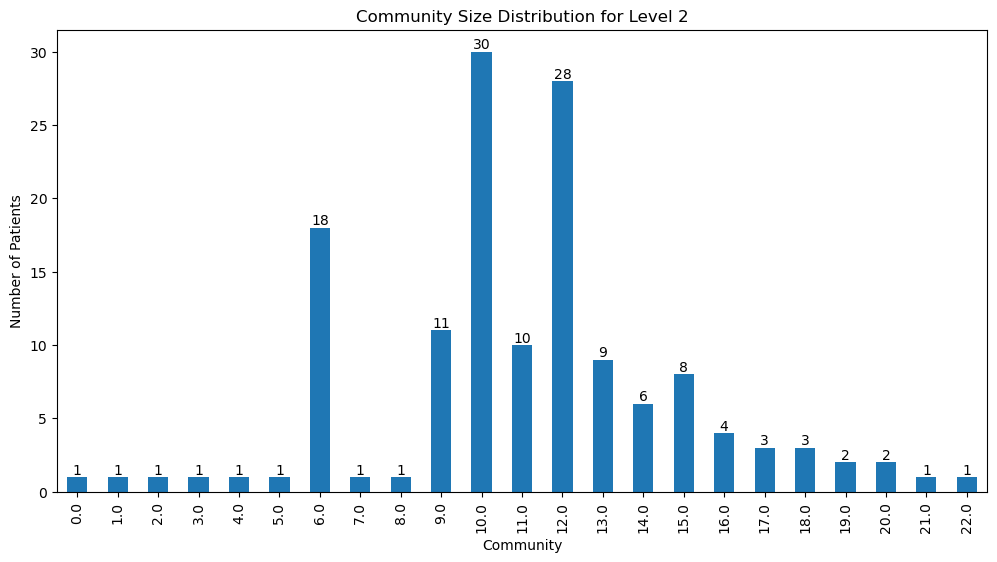

In [877]:
# get distribution of patients in communities for level 2, with annotation on bar
leiden2_patient_df['community'].value_counts().sort_index().plot(kind='bar', figsize=(12, 6), title='Community Size Distribution for Level 2')
plt.xlabel('Community')
plt.ylabel('Number of Patients')
for i, v in enumerate(leiden2_patient_df['community'].value_counts().sort_index()):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.show()

In [878]:
print_value_counts(leiden2_patient_df, 10, 'COHORT')
print_value_counts(leiden2_patient_df, 10, 'originId')
print_value_counts(leiden2_patient_df, 10, 'CLL_EPITYPE')
print_value_counts(leiden2_patient_df, 10, 'TUMOR_MOLECULAR_SUBTYPE')

Value counts for COHORT:
COHORT
GCLLSG    29
ICGC       1
Name: count, dtype: int64


Value counts for originId:
originId
6    29
1     1
Name: count, dtype: int64


Value counts for CLL_EPITYPE:
CLL_EPITYPE
unclassified    30
Name: count, dtype: int64


Value counts for TUMOR_MOLECULAR_SUBTYPE:
TUMOR_MOLECULAR_SUBTYPE
U-CLL    20
M-CLL     8
Name: count, dtype: int64




In [879]:
print_value_counts(leiden2_patient_df, 12, 'COHORT')
print_value_counts(leiden2_patient_df, 12, 'originId')
print_value_counts(leiden2_patient_df, 12, 'CLL_EPITYPE')
print_value_counts(leiden2_patient_df, 12, 'TUMOR_MOLECULAR_SUBTYPE')

Value counts for COHORT:
COHORT
GCLLSG    27
NHLBI      1
Name: count, dtype: int64


Value counts for originId:
originId
7    27
8     1
Name: count, dtype: int64


Value counts for CLL_EPITYPE:
CLL_EPITYPE
unclassified    28
Name: count, dtype: int64


Value counts for TUMOR_MOLECULAR_SUBTYPE:
TUMOR_MOLECULAR_SUBTYPE
M-CLL    15
U-CLL    13
Name: count, dtype: int64




In [880]:
print_value_counts(leiden2_patient_df, 6, 'COHORT')
print_value_counts(leiden2_patient_df, 6, 'originId')
print_value_counts(leiden2_patient_df, 6, 'CLL_EPITYPE')
print_value_counts(leiden2_patient_df, 6, 'TUMOR_MOLECULAR_SUBTYPE')

Value counts for COHORT:
COHORT
ICGC    14
DFCI     4
Name: count, dtype: int64


Value counts for originId:
originId
1    14
3     4
Name: count, dtype: int64


Value counts for CLL_EPITYPE:
CLL_EPITYPE
unclassified    6
m-CLL           5
n-CLL           5
i-CLL           2
Name: count, dtype: int64


Value counts for TUMOR_MOLECULAR_SUBTYPE:
TUMOR_MOLECULAR_SUBTYPE
U-CLL    10
M-CLL     8
Name: count, dtype: int64




## Add comm_id to patient_df from hybrid

In [881]:
def join_communities_with_patient_data_slpa(community, patient_df):
    """
    Joins SLPA communities with patient data based on nodeId.
    """
    communities = community.communities
    communities_df = pd.DataFrame({
        'nodeId': [node for comm in communities for node in comm],
        'community': [idx for idx, comm in enumerate(communities) for node in comm]
    })
    
    merged_df = pd.merge(patient_df, communities_df, on='nodeId', how='left')
    return merged_df

In [882]:
slpa_on_leiden_level0_patient_df = join_communities_with_patient_data_slpa(slpa_on_leiden_level0, patient_df)
slpa_on_leiden_level0_patient_df.head(10)[['nodeId', 'community', 'Patient', 'patientId']]

,nodeId,community,Patient,patientId
0,0,466,Patient_P-CRC-0001,P-CRC-0001
1,27,529,Patient_P-CRC-0002,P-CRC-0002
2,36,972,Patient_P-CRC-0003,P-CRC-0003
3,45,231,Patient_P-CRC-0004,P-CRC-0004
4,59,555,Patient_P-CRC-0005,P-CRC-0005
5,64,488,Patient_P-CRC-0006,P-CRC-0006
6,72,342,Patient_P-CRC-0007,P-CRC-0007
7,82,511,Patient_P-CRC-0008,P-CRC-0008
8,89,806,Patient_P-CRC-0009,P-CRC-0009
9,99,655,Patient_P-CRC-0010,P-CRC-0010


In [883]:
communities = slpa_on_leiden_level0.communities
communities_df = pd.DataFrame({
        'nodeId': [node for comm in communities for node in comm],
        'community': [idx for idx, comm in enumerate(communities) for node in comm]
})
# keep only those nodeids that map to Patient_
communities_df = communities_df[communities_df['nodeId'].isin(leiden0_patient_df['nodeId'])]
print(communities_df.shape, patient_df.shape)
print("Communities found with at least 1 patient: ", communities_df['community'].nunique())

(1143, 2) (1143, 30)
Communities found with at least 1 patient:  984


In [884]:
# display patients in communities_df belonging to more than 1 community
patients_in_multiple_comms = communities_df['nodeId'].value_counts()[communities_df['nodeId'].value_counts() > 1]
print(f"Patients in multiple communities: {patients_in_multiple_comms.shape[0]}")

Patients in multiple communities: 0


In [885]:
# keep only those communities that have more than 1 patient
slpa_on_leiden_level0_patient_df.groupby('community').filter(lambda x: len(x) > 1).groupby('community').size().sort_values(ascending=False)

community
19    160
dtype: int64

In [886]:
big_group = slpa_on_leiden_level0_patient_df[slpa_on_leiden_level0_patient_df['community']==19]

In [887]:
big_group['COHORT'].value_counts()

COHORT
ICGC      65
GCLLSG    60
DFCI      32
MDACC      2
NHLBI      1
Name: count, dtype: int64

In [888]:
big_group['originId'].value_counts()

originId
1    65
7    31
6    29
3    25
5     7
9     2
8     1
Name: count, dtype: int64

In [889]:
big_group['CLL_EPITYPE'].value_counts()

CLL_EPITYPE
unclassified    108
m-CLL            24
n-CLL            23
i-CLL             5
Name: count, dtype: int64

In [890]:
big_group['TUMOR_MOLECULAR_SUBTYPE'].value_counts()

TUMOR_MOLECULAR_SUBTYPE
U-CLL    80
M-CLL    65
Name: count, dtype: int64

In [891]:
# get percentage of all nodes, not just patient nodes, belonging in more than 1 community in slpa_on_leiden_level0.communities
node_to_communities_map = {}
for idx, comm in enumerate(slpa_on_leiden_level0.communities):
    for node in comm:
        if node not in node_to_communities_map:
            node_to_communities_map[node] = []
        node_to_communities_map[node].append(idx)

# Calculate the percentage of nodes in more than 1 community
nodes_in_multiple_comms = sum(1 for communities in node_to_communities_map.values() if len(communities) > 1)
print(f"Total nodes in multiple communities: {nodes_in_multiple_comms}")
nodes_list_in_multiple_comms = [node for node, communities in node_to_communities_map.items() if len(communities) > 1]
print(f"Nodes in multiple communities: {nodes_list_in_multiple_comms}")
print(mapping[168], node_to_communities_map[168])
total_nodes = len(node_to_communities_map)
print(f"Total nodes: {total_nodes}")
percentage_in_multiple_comms = (nodes_in_multiple_comms / total_nodes) * 100
print(f"Percentage of nodes in more than 1 community: {percentage_in_multiple_comms:.2f}%")

Total nodes in multiple communities: 1
Nodes in multiple communities: [168]
AGE_56.0 [19, 747]
Total nodes: 146636
Percentage of nodes in more than 1 community: 0.00%


In [892]:
# caluclate nmi and ari for slpa_on_leiden_level0_patient_df['community'] based on cll_epitype and tumor_molecular_subtype
def calculate_nmi_ari(df, community_col, label_col):
    """
    Calculate Normalized Mutual Information (NMI) and Adjusted Rand Index (ARI) for the given community and label columns.
    """
    # drop rows where either community or label is NaN
    df = df.dropna(subset=[community_col, label_col])
    nmi = normalized_mutual_info_score(df[community_col], df[label_col])
    ari = adjusted_rand_score(df[community_col], df[label_col])
    return nmi, ari

# Calculate NMI and ARI for CLL_EPITYPE
nmi_cll_epitype, ari_cll_epitype = calculate_nmi_ari(slpa_on_leiden_level0_patient_df, 'community', 'CLL_EPITYPE')
print(f"NMI for CLL_EPITYPE: {nmi_cll_epitype:.4f}, ARI: {ari_cll_epitype:.4f}")    
# Calculate NMI and ARI for TUMOR_MOLECULAR_SUBTYPE
nmi_tumor_molecular_subtype, ari_tumor_molecular_subtype = calculate_nmi_ari(slpa_on_leiden_level0_patient_df, 'community', 'TUMOR_MOLECULAR_SUBTYPE')
print(f"NMI for TUMOR_MOLECULAR_SUBTYPE: {nmi_tumor_molecular_subtype:.4f}, ARI: {ari_tumor_molecular_subtype:.4f}")

NMI for CLL_EPITYPE: 0.3122, ARI: 0.0301
NMI for TUMOR_MOLECULAR_SUBTYPE: 0.1725, ARI: 0.0001


## Adding comm_id to patient_df from slpa

In [893]:
slpa_patient_df = join_communities_with_patient_data_slpa(slpa_communities, patient_df)
slpa_patient_df.head(10)[['nodeId', 'community', 'Patient', 'patientId']]

,nodeId,community,Patient,patientId
0,0,0,Patient_P-CRC-0001,P-CRC-0001
1,27,0,Patient_P-CRC-0002,P-CRC-0002
2,36,0,Patient_P-CRC-0003,P-CRC-0003
3,45,0,Patient_P-CRC-0004,P-CRC-0004
4,59,0,Patient_P-CRC-0005,P-CRC-0005
5,64,0,Patient_P-CRC-0006,P-CRC-0006
6,72,0,Patient_P-CRC-0007,P-CRC-0007
7,82,0,Patient_P-CRC-0008,P-CRC-0008
8,89,0,Patient_P-CRC-0009,P-CRC-0009
9,99,0,Patient_P-CRC-0010,P-CRC-0010


In [894]:
communities = slpa_communities.communities
communities_df = pd.DataFrame({
        'nodeId': [node for comm in communities for node in comm],
        'community': [idx for idx, comm in enumerate(communities) for node in comm]
})
# keep only those nodeids that map to Patient_
communities_df = communities_df[communities_df['nodeId'].isin(leiden0_patient_df['nodeId'])]
print(communities_df.shape, patient_df.shape)
print("Communities found with at least 1 patient: ", communities_df['community'].nunique())
# all communities have at least 1 patient

(1173, 2) (1143, 30)
Communities found with at least 1 patient:  44


In [895]:
# display patients in communities_df belonging to more than 1 community
patients_in_multiple_comms = communities_df['nodeId'].value_counts()[communities_df['nodeId'].value_counts() > 1]
print(f"Patients in multiple communities: {patients_in_multiple_comms.shape[0]}")

Patients in multiple communities: 30


In [896]:
# keep only those communities that have more than 1 patient
slpa_patient_df.groupby('community').filter(lambda x: len(x) > 1).groupby('community').size().sort_values(ascending=False)

community
0    1130
dtype: int64

In [897]:
big_group = slpa_patient_df[slpa_patient_df['community']==0]

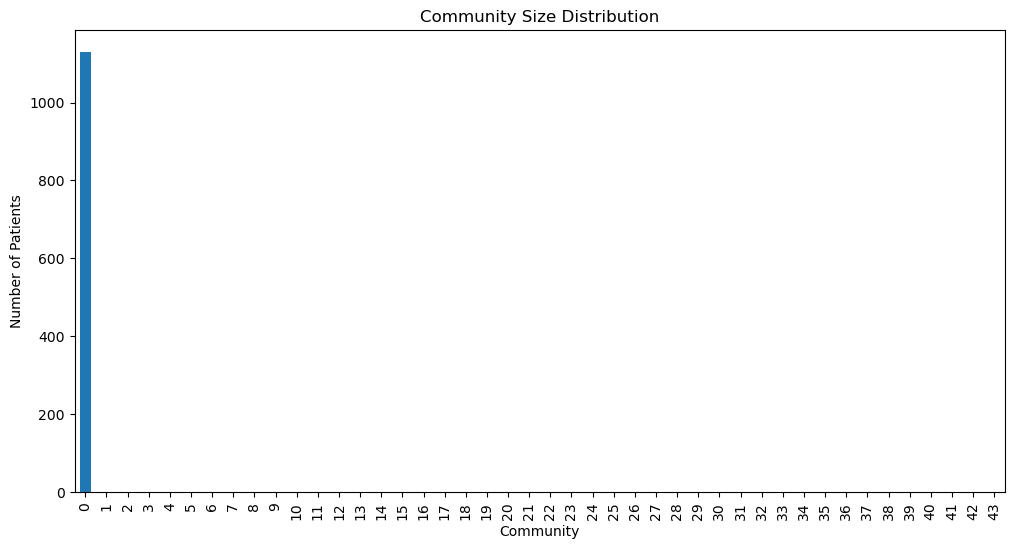

In [898]:
slpa_patient_df['community'].value_counts().sort_index().plot(kind='bar', figsize=(12, 6), title='Community Size Distribution')
plt.xlabel('Community')
plt.ylabel('Number of Patients')
plt.show()

In [899]:
slpa_patient_df['community'].value_counts()

# 1130 patient in comm 0,
# 30 of these also have their own community,
# and 11 present in only their own community

community
0     1130
32       1
29       1
25       1
12       1
19       1
16       1
24       1
17       1
31       1
3        1
18       1
22       1
10       1
4        1
1        1
8        1
7        1
11       1
6        1
5        1
20       1
14       1
21       1
15       1
33       1
34       1
40       1
41       1
35       1
9        1
23       1
37       1
36       1
27       1
28       1
42       1
13       1
43       1
38       1
39       1
26       1
30       1
2        1
Name: count, dtype: int64

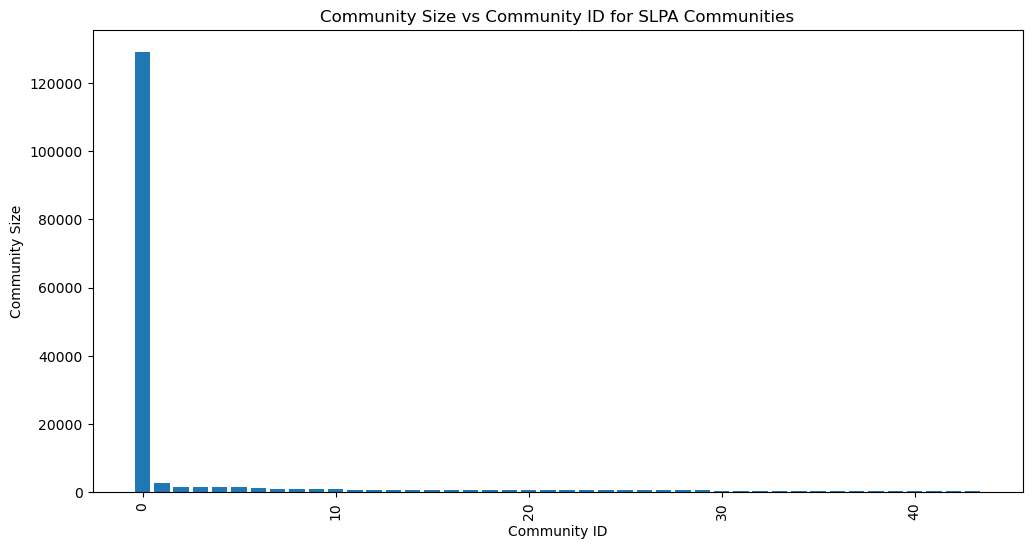

In [900]:
# plot community size vs community id 
comm_sizes = [len(c) for c in slpa_communities.communities]
plt.figure(figsize=(12, 6))
plt.bar(range(len(comm_sizes)), comm_sizes)
plt.xlabel('Community ID')
plt.ylabel('Community Size')
plt.title('Community Size vs Community ID for SLPA Communities')
plt.xticks(rotation=90)
plt.show()

In [901]:
# get percentage and list of all nodes, not just patient nodes, belonging in more than 1 community
node_to_communities_map = {}
for idx, comm in enumerate(slpa_communities.communities):
    for node in comm:
        if node not in node_to_communities_map:
            node_to_communities_map[node] = []
        node_to_communities_map[node].append(idx)
# Calculate the percentage of nodes in more than 1 community
nodes_in_multiple_comms = sum(1 for communities in node_to_communities_map.values() if len(communities) > 1)
print(f"Total nodes in multiple communities: {nodes_in_multiple_comms}")
total_nodes = len(node_to_communities_map)
print(f"Total nodes: {total_nodes}")
percentage_in_multiple_comms = (nodes_in_multiple_comms / total_nodes) * 100
print(f"Percentage of nodes in more than 1 community: {percentage_in_multiple_comms:.2f}%")

Total nodes in multiple communities: 9198
Total nodes: 146636
Percentage of nodes in more than 1 community: 6.27%


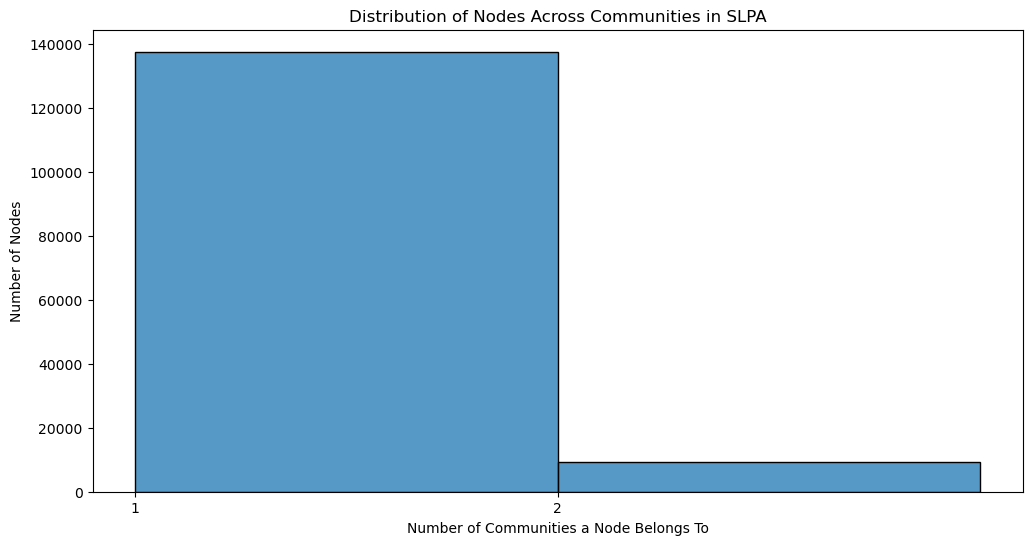

137438 nodes belong to only 1 community
9198 nodes belong to 2 communities


In [902]:
# get how many communities a node belongs to and plot where x is number of communities and y is number of nodes
node_community_counts = [len(communities) for communities in node_to_communities_map.values()]
plt.figure(figsize=(12, 6))
sns.histplot(node_community_counts, bins=range(1, max(node_community_counts) + 2), kde=False)
plt.xlabel('Number of Communities a Node Belongs To')
plt.ylabel('Number of Nodes')
plt.title('Distribution of Nodes Across Communities in SLPA')
plt.xticks(range(1, max(node_community_counts) + 1))
plt.show()  

print(node_community_counts.count(1), "nodes belong to only 1 community")
print(node_community_counts.count(2), "nodes belong to 2 communities")

## Visualise graph using Gephi

In [903]:
def export_patient_community_and_edges(community, mapping_df, triplets_df, output_prefix="patient"):
    """
    Given a cdlib read_community_csv community object, a mapping DataFrame, and a triplets DataFrame,
    saves two CSVs:
      1. {output_prefix}_nodeid_nodename_community.csv: nodeid, nodename, community_id for patient nodes only
      2. {output_prefix}_sourcenodeid_targetnodeid.csv: source nodeid, target nodeid for edges between patient nodes only
    """
    # Prepare mapping dicts
    if 'node' in mapping_df.columns and 'original_label' in mapping_df.columns:
        nodeid_to_nodename = mapping_df.set_index('node')['original_label'].to_dict()
    elif 'nodeid' in mapping_df.columns and 'nodename' in mapping_df.columns:
        nodeid_to_nodename = mapping_df.set_index('nodeid')['nodename'].to_dict()
    else:
        raise ValueError("mapping_df must have columns ['node', 'original_label'] or ['nodeid', 'nodename']")
    
    # Build nodeid -> community_id for all nodes in communities
    nodeid_to_commid = {}
    for comm_id, comm in enumerate(community.communities):
        for node in comm:
            nodeid_to_commid[node] = comm_id

    # Filter mapping to patient nodes only
    patient_rows = []
    for nodeid, nodename in nodeid_to_nodename.items():
        if str(nodename).startswith("Patient_"):
            comm_id = nodeid_to_commid.get(nodeid, -1)
            patient_rows.append({'nodeid': nodeid, 'nodename': nodename, 'community_id': comm_id})
    patient_df = pd.DataFrame(patient_rows)
    patient_df.to_csv(f"{output_prefix}_nodeid_nodename_community.csv", index=False)

    # Prepare mapping from nodename to nodeid for triplets
    nodename_to_nodeid = {v: k for k, v in nodeid_to_nodename.items()}

    # Filter triplets to patient-patient edges only
    triplets_df['Source'] = triplets_df['subject'].map(nodename_to_nodeid)
    triplets_df['Target'] = triplets_df['object'].map(nodename_to_nodeid)
    patient_edges = triplets_df.dropna(subset=['Source', 'Target'])
    patient_edges = patient_edges[['Source', 'Target']].astype(int)
    patient_edges.to_csv(f"{output_prefix}_sourcenodeid_targetnodeid.csv", index=False)

    print(f"Saved {output_prefix}_nodeid_nodename_community.csv and {output_prefix}_sourcenodeid_targetnodeid.csv")

In [904]:
# export_patient_community_and_edges(
#     community=heirarchical_leiden_level0,
#     mapping_df=pd.read_csv("../cdlib-trial/data/trial/mapping.csv"),
#     triplets_df=pd.read_csv("../cdlib-trial/data/trial/kg_triplets_for_trial.csv"),
#     output_prefix="trial"
# )